In [ ]:
IMG_H = 128 
IMG_W = 128
seed = 101

In [ ]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#download dataset

In [ ]:
import requests
from zipfile import ZipFile

def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename
file_name=download_file("https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip")
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

File Name                                             Modified             Size
images/                                        2020-07-09 12:36:14            0
images/imgs_part_2.zip                         2020-07-09 12:36:14   1126646990
images/imgs_part_3.zip                         2020-07-09 12:58:40   1220565093
images/imgs_part_1.zip                         2020-07-09 13:29:36   1245184680
metadata.csv                                   2020-07-09 13:53:28       316209
Extracting all the files now...
Done!


In [ ]:
file_name="images/imgs_part_1.zip"
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	# zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')
file_name="images/imgs_part_2.zip"
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	# zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')
file_name="images/imgs_part_3.zip"
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	# zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

Extracting all the files now...
Done!
Extracting all the files now...
Done!
Extracting all the files now...
Done!


# move all images to one folder

In [ ]:
import os
import shutil
os.mkdir("/content/all_images")
source_dir="/content/imgs_part_1"
file_names = os.listdir(source_dir)
for file_name in file_names:
    # print(os.path.join(source_dir, file_name))
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

source_dir="/content/imgs_part_2"
file_names = os.listdir(source_dir)
for file_name in file_names:
    # print(os.path.join(source_dir, file_name))
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

source_dir="/content/imgs_part_3"
file_names = os.listdir(source_dir)
for file_name in file_names:
    # print(os.path.join(source_dir, file_name))
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

In [ ]:
import pandas as pd
import shutil
from keras import Model
import tensorflow as tf
from keras.applications.resnet import ResNet50,preprocess_input
from keras.layers import Conv2D,Flatten,Dense,MaxPool2D,BatchNormalization,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

# read meta

In [ ]:
metadata_path="/content/metadata.csv"
meta = pd.read_csv(metadata_path)
images = meta['img_id']
target = meta['diagnostic']
meta=meta.drop(['patient_id','lesion_id'],axis=1)
# print(target.unique())

# move all images in single folder 
# create folder called images inside this folder create subfolders that names = target.unique()


# for diag in target.unique():
#   os.mkdir("/content/all_images/"+diag)

In [ ]:
meta['smoke']=meta['smoke'].map({True: 2, False: 1})
meta['smoke']=meta['smoke'].fillna(0)

meta['drink']=meta['drink'].map({True: 2, False: 1})
meta['drink']=meta['drink'].fillna(0)

meta['pesticide']=meta['pesticide'].map({True: 2, False: 1})
meta['pesticide']=meta['pesticide'].fillna(0)

# 
meta['gender']=meta['gender'].map({'FEMALE': 2, 'MALE': 1})
meta['gender']=meta['gender'].fillna(0)



meta['skin_cancer_history']=meta['skin_cancer_history'].map({True: 2, False: 1})
meta['skin_cancer_history']=meta['skin_cancer_history'].fillna(0)

meta['cancer_history']=meta['cancer_history'].map({True: 2, False: 1})
meta['cancer_history']=meta['cancer_history'].fillna(0)

meta['has_piped_water']=meta['has_piped_water'].map({True: 2, False: 1})
meta['has_piped_water']=meta['has_piped_water'].fillna(0)

meta['has_sewage_system']=meta['has_sewage_system'].map({True: 2, False: 1})
meta['has_sewage_system']=meta['has_sewage_system'].fillna(0)
# digits
meta['fitspatrick']=meta['fitspatrick'].fillna(-1)
meta['diameter_1']=meta['diameter_1'].fillna(-1)
meta['diameter_2']=meta['diameter_2'].fillna(-1)

meta['itch']=meta['itch'].map({'True': 2, 'False': 1,'UNK':0})
meta['grew']=meta['grew'].map({'True': 2, 'False': 1,'UNK':0})
meta['hurt']=meta['hurt'].map({'True': 2, 'False': 1,'UNK':0})
meta['changed']=meta['changed'].map({'True': 2, 'False': 1,'UNK':0})
meta['bleed']=meta['bleed'].map({'True': 2, 'False': 1,'UNK':0})
meta['elevation']=meta['elevation'].map({'True': 2, 'False': 1,'UNK':0})

meta['background_father']=meta['background_father'].fillna('None')
meta['background_mother']=meta['background_mother'].fillna('None')

In [ ]:
will_be_hot=[]
for i in meta.columns:
  if meta[i].dtypes=='O':
    print(i)
    will_be_hot.append(i)

background_father
background_mother
region
diagnostic
img_id


In [ ]:
meta

,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,0.0,0.0,None,None,8,0.0,0.0,0.0,0.0,0.0,...,-1.0,NEV,1,1,1,1,1,1,PAT_1516_1765_530.png,False
1,1.0,1.0,POMERANIA,POMERANIA,55,1.0,2.0,2.0,2.0,2.0,...,5.0,BCC,2,2,1,2,2,2,PAT_46_881_939.png,True
2,0.0,0.0,None,None,77,0.0,0.0,0.0,0.0,0.0,...,-1.0,ACK,2,1,1,1,1,1,PAT_1545_1867_547.png,False
3,0.0,0.0,None,None,75,0.0,0.0,0.0,0.0,0.0,...,-1.0,ACK,2,1,1,1,1,1,PAT_1989_4061_934.png,False
4,1.0,2.0,POMERANIA,POMERANIA,79,1.0,1.0,2.0,1.0,1.0,...,5.0,BCC,2,2,1,1,2,2,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,0.0,0.0,None,None,73,0.0,0.0,0.0,0.0,0.0,...,-1.0,ACK,2,1,1,1,1,1,PAT_1708_3156_175.png,False
2294,1.0,1.0,POMERANIA,POMERANIA,55,1.0,2.0,2.0,2.0,2.0,...,12.0,BCC,2,2,1,2,1,1,PAT_46_880_140.png,True
2295,0.0,0.0,None,None,74,0.0,0.0,0.0,0.0,0.0,...,-1.0,SEK,1,1,1,1,1,1,PAT_1343_1217_404.png,False
2296,1.0,1.0,POMERANIA,POMERANIA,58,2.0,2.0,2.0,2.0,1.0,...,4.0,BCC,2,1,1,1,1,2,PAT_326_690_823.png,True


# Segmentation with UNET

In [ ]:
img_path="/content/drive/MyDrive/Segmentation151/Original"
mask_path="/content/drive/MyDrive/Segmentation151/Mask"

In [ ]:
import os
import glob
import tensorflow as tf
images_paths=sorted(glob.glob(img_path+"/*"))
masks_paths=sorted(glob.glob(mask_path+"/*"))
images=[]
target=[]
for indx,imgPath in enumerate(images_paths):
    # print(imgPath.split('/')[-1])
    # if imgPath.split('/')[-1] not in dic['ACK']:
    #   continue
    image=tf.keras.utils.load_img(imgPath,target_size=(IMG_H,IMG_W))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = cv2.cvtColor(input_arr,cv2.COLOR_BGR2RGB)
    input_arr=np.array(input_arr)
    input_arr=input_arr/255
    images.append(np.copy(input_arr))

    mask=tf.keras.utils.load_img(masks_paths[indx],target_size=(IMG_H,IMG_W))
    input_arr = tf.keras.preprocessing.image.img_to_array(mask)

    # print(input_arr.shape)
    # color_mode="grayscale"
    # plt.show()
    input_arr = cv2.cvtColor(input_arr,cv2.COLOR_BGR2GRAY)
    input_arr=np.array(input_arr)
    input_arr=input_arr/255
    
    target.append(np.copy(input_arr))
    # print(imgPath.split('/')[-1].split('.png')[0]==masks_paths[indx].split('/')[-1].split('.png')[0])

In [ ]:
len(images)

151

In [ ]:
trainX=tf.convert_to_tensor(images[:-3])
trainY=tf.convert_to_tensor(target[:-3])
valX=tf.convert_to_tensor(images[-3:])
valY=tf.convert_to_tensor(target[-3:])

In [ ]:
print("train",trainX.shape)
print("val",valX.shape)

train (148, 128, 128, 3)
val (3, 128, 128, 3)


#code2

In [ ]:
import tensorflow as tf


IMG_WIDTH = IMG_W
IMG_HEIGHT = IMG_H
IMG_CHANNELS = 3

def build_model():
#Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  # s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
  
  return tf.keras.Model(inputs=[inputs], outputs=[outputs])


# model.summary()

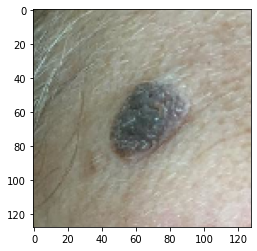

In [ ]:
image = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)

plt.imshow(image)

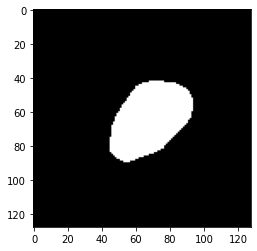

In [ ]:
images[0].shape
image = cv2.cvtColor(target[0], cv2.COLOR_GRAY2RGB)
plt.imshow(image)

#seg train

In [ ]:
# #getting features from images
from keras.applications.efficientnet import EfficientNetB4
import random as rn
import tensorflow as tf
import numpy as np
from keras import backend as K

from keras import applications
from keras.applications.efficientnet import EfficientNetB4
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# seed=1   
num_cores=1  
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,
                              inter_op_parallelism_threads=num_cores, 
                              allow_soft_placement=True,
                              device_count = {'CPU' : 1, 'GPU' : 0})
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)
# metrics = ['jaccard_index',
#            'pixelwise_sensitivity',
#            'pixelwise_specificity']

# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
# model.compile(optimizer=opt, loss="binary_crossentropy",metrics=['accuracy'])
# Set hyperparameters of our training model
# num_classes = 1
# epochs = 30
# learning_rate = 1e-4
# loss = 'crossentropy' # Function will interpret to use binary crossentropy when num_classes=1

seg_model=build_model()
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Compile model
# compile_model(model, num_classes, metrics, loss, learning_rate)
seg_model.fit(trainX,trainY,batch_size=3 ,epochs=300,validation_data=(valX,valY))

Epoch 1/300
50/50 [==============================] - 17s 35ms/step - loss: 0.4441 - accuracy: 0.8156 - val_loss: 0.3376 - val_accuracy: 0.8481
Epoch 2/300
50/50 [==============================] - 1s 14ms/step - loss: 0.4138 - accuracy: 0.8338 - val_loss: 0.3437 - val_accuracy: 0.8481
Epoch 3/300
50/50 [==============================] - 1s 13ms/step - loss: 0.3360 - accuracy: 0.8338 - val_loss: 0.3059 - val_accuracy: 0.8481
Epoch 4/300
50/50 [==============================] - 1s 13ms/step - loss: 0.3480 - accuracy: 0.8338 - val_loss: 0.3458 - val_accuracy: 0.8481
Epoch 5/300
50/50 [==============================] - 1s 13ms/step - loss: 0.3419 - accuracy: 0.8339 - val_loss: 0.2941 - val_accuracy: 0.8481
Epoch 6/300
50/50 [==============================] - 1s 14ms/step - loss: 0.3098 - accuracy: 0.8358 - val_loss: 0.2445 - val_accuracy: 0.8492
Epoch 7/300
50/50 [==============================] - 1s 14ms/step - loss: 0.2857 - accuracy: 0.8548 - val_loss: 0.3024 - val_accuracy: 0.9113
Epoch

#test

In [ ]:
# first_ack

img_name="PAT_1818_3568_132.png"
image=tf.keras.utils.load_img("/content/all_images/"+img_name,target_size=(IMG_H,IMG_W))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = cv2.cvtColor(input_arr,cv2.COLOR_BGR2RGB)
input_arr=np.array(input_arr)
input_img=[input_arr/255]
# first_ack

In [ ]:
input_img_tf=tf.convert_to_tensor(input_img)
mask_=seg_model.predict(input_img_tf)*255
mask_=mask_.squeeze()
mask_.reshape(-1)[np.argmax(mask_)]

255.0

In [ ]:
mask_.shape

(128, 128)

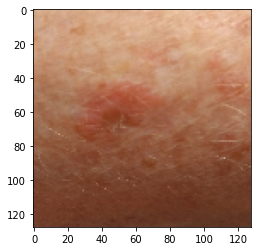

In [ ]:
image = cv2.cvtColor(input_img[0], cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [ ]:
mask_[mask_>10]=255
mask_[mask_<10]=0

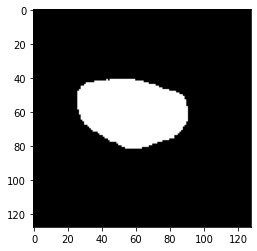

In [ ]:
# plt.imshow()
# mask_[0]=mask_[0]*255
plt.imshow(np.squeeze(mask_), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

In [ ]:
res = cv2.bitwise_and(image,image,mask = mask_.astype(np.uint8))

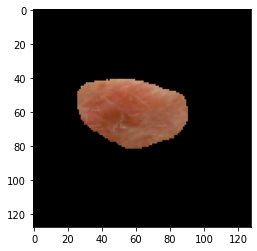

In [ ]:
plt.imshow(res)

#save segmanted images

In [ ]:
import os
import glob
import tensorflow as tf

allimgs_path = "/content/all_images/"
images_paths=sorted(glob.glob(allimgs_path+"/*"))

result = {}
for indx,allimgs_path in enumerate(images_paths):
    image=tf.keras.utils.load_img(allimgs_path,target_size=(IMG_H,IMG_W))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = cv2.cvtColor(input_arr,cv2.COLOR_BGR2RGB)
    input_arr=np.array(input_arr)
    input_img=[input_arr/255]

    input_img_tf=tf.convert_to_tensor(input_img)
    mask_=seg_model.predict(input_img_tf)*255
    mask_=mask_.squeeze()*255
    mask_[mask_>50]=255
    mask_[mask_<50]=0  

    image = cv2.cvtColor(input_img[0], cv2.COLOR_BGR2RGB)
    res = cv2.bitwise_and(image,image,mask = mask_.astype(np.uint8))
    # result.append(np.copy(res))
    result[allimgs_path.split('/')[-1]] = res

#pre-processing

In [ ]:
for hot in will_be_hot:
  if hot=="img_id" :
    continue
  ls=meta[hot].values.tolist()
  le = preprocessing.LabelEncoder()
  meta[hot] = le.fit_transform(meta[hot]) 

In [ ]:
# #getting features from images

from keras.applications.efficientnet import EfficientNetB4
import random as rn
import tensorflow as tf
import numpy as np
from keras import backend as K

from keras import applications
from keras.applications.efficientnet import EfficientNetB4
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

# seed=1   
num_cores=1  
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,
                              inter_op_parallelism_threads=num_cores, 
                              allow_soft_placement=True,
                              device_count = {'CPU' : 1, 'GPU' : 0})
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

#getting features from images
model = tf.keras.applications.MobileNetV2(input_shape=(380, 380, 3), include_top=False, weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
for indx,i in enumerate(meta['img_id']):
    input_arr = tf.keras.preprocessing.image.img_to_array(result[i])
    input_arr = cv2.cvtColor(input_arr,cv2.COLOR_BGR2RGB)
    input_arr = cv2.resize(input_arr,(380,380))
    input_arr=np.array([input_arr])
    input_arr=input_arr/255
    features=model.predict(input_arr)
    nx, ny,_ = features[0].shape
    d2_train_dataset = features[0].reshape(nx*ny*_)
    meta['img_id'][indx]=d2_train_dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


#split data

In [ ]:
train,test0=train_test_split(meta,test_size=0.2,random_state=seed)
valid,test=train_test_split(test0,test_size=0.5,random_state=seed)

In [ ]:
train['img_id'].shape

(1838,)

In [ ]:
# train['img_id'][train.index[0]].shape
imgF=[]
for indx in train.index:
  imgF.append(train['img_id'][indx])
imgF_tst=[]
for indx in test.index:
  imgF_tst.append(test['img_id'][indx])

In [ ]:
imgF_valid=[]
for indx in valid.index:
  imgF_valid.append(valid['img_id'][indx])

In [ ]:
np.array(imgF).shape

(1838, 184320)

In [ ]:
target=train['diagnostic']
x=train.drop(['diagnostic','img_id','background_father'],axis=1)#

target_test=test['diagnostic']
x_test=test.drop(['diagnostic','img_id','background_father'],axis=1)

In [ ]:
target_valid=valid['diagnostic']
x_valid=valid.drop(['diagnostic','img_id','background_father'],axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

meta_clf = RandomForestClassifier(random_state=seed)
img_clf = LogisticRegression(random_state=seed,max_iter=110)
img_clf.fit(imgF, target)
meta_clf.fit(x, target)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RandomForestClassifier(random_state=101)

In [ ]:
predicted_img_labels = img_clf.predict_proba(imgF_tst)
predicted_meta_labels = meta_clf.predict_proba(x_test)

In [ ]:
predicted=[]
for i in range(len(predicted_img_labels)): 
  ls=[]
  for indx,k in enumerate(predicted_img_labels[i]):
    ls.append(.5*k+predicted_meta_labels[i][indx])
  predicted.append(np.argmax(np.array(ls)))

In [ ]:
# import numpy as np
# from sklearn import metrics
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelBinarizer
# import seaborn as sns

# def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
#         lb = LabelBinarizer()
#         lb.fit(y_test)
#         y_test = lb.transform(y_test)
#         y_pred = lb.transform(y_pred)
#         return metrics.roc_auc_score(y_test, y_pred, average=average)
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)

        return  metrics.accuracy_score(y_test,y_pred)
        # return metrics.roc_auc_score(y_test, y_pred, average=average)

#meta + image in one model

In [ ]:
len(predicted_meta_labels)

230

In [ ]:
predicted_img_labels = img_clf.predict_proba(imgF)
predicted_meta_labels = meta_clf.predict_proba(x)

In [ ]:
predicted_img_labels_tst = img_clf.predict_proba(imgF_tst)
predicted_meta_labels_tst = meta_clf.predict_proba(x_test)

In [ ]:
predicted_img_labels_valid = img_clf.predict_proba(imgF_valid)
predicted_meta_labels_valid = meta_clf.predict_proba(x_valid)

In [ ]:
pre_img=[]
for i in predicted_img_labels_tst:
  pre_img.append(np.argmax(i))

pre_meta=[]
for i in predicted_meta_labels_tst:
  pre_meta.append(np.argmax(i))

In [ ]:
print('img',multiclass_roc_auc_score(pre_img,target_test)*100)
print('meta',multiclass_roc_auc_score(pre_meta,target_test)*100)
# img 60
# meta 85.8

img 50.8695652173913
meta 85.65217391304348


In [ ]:
all_x=[]
all_im=[]
all_y=[]
for i in range(len(predicted_meta_labels_valid)):
  all_x.append(predicted_meta_labels_valid[i])
  all_im.append(predicted_img_labels_valid[i])
  all_y.append(target_valid.iloc[i])

  
  all_x.append(predicted_meta_labels_tst[i])
  all_im.append(predicted_img_labels_tst[i])
  all_y.append(target_test.iloc[i])

In [ ]:
# df = pd.DataFrame(lst)
dict = {'meta': all_x, 'image': all_im, 'label': all_y} 
df = pd.DataFrame(dict)

In [ ]:
df

,meta,image,label
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.10388553022474833, 0.47777055885421044, 0.0...",0
1,"[0.21, 0.0, 0.0, 0.0, 0.0, 0.79]","[0.19673791722529016, 0.5416448801906999, 0.02...",5
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.43418109219648526, 0.309038400691277, 0.014...",0
3,"[0.93, 0.0, 0.0, 0.01, 0.0, 0.06]","[0.20039096542214813, 0.35878246731047164, 0.0...",0
4,"[0.64, 0.19, 0.0, 0.0, 0.17, 0.0]","[0.174434870681418, 0.5542116738397734, 0.0482...",0
...,...,...,...
455,"[0.02, 0.8, 0.0, 0.01, 0.16, 0.01]","[0.2176837332230748, 0.4398080994279553, 0.023...",1
456,"[0.09, 0.73, 0.0, 0.0, 0.18, 0.0]","[0.6450630599705547, 0.24652227863469206, 0.00...",1
457,"[0.04, 0.88, 0.0, 0.01, 0.07, 0.0]","[0.22475307933879268, 0.45085972399248864, 0.0...",1
458,"[0.05, 0.24, 0.2, 0.07, 0.42, 0.02]","[0.16903877323390368, 0.5403384018652849, 0.06...",3


In [ ]:
train,test0=train_test_split(df,test_size=0.2,random_state=seed)
test,valid=train_test_split(test0,test_size=0.5,random_state=seed)

In [ ]:
x_train=train.drop(['label'],axis=1)
y_train=train['label']
x_test=test.drop(['label'],axis=1)
y_test=test['label']
x_valid=valid.drop(['label'],axis=1)
y_valid=valid['label']

In [ ]:
import os 
import random as rn
import tensorflow as tf
import numpy as np
from keras import backend as K
# seed=1
num_cores=1  
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,
                              inter_op_parallelism_threads=num_cores, 
                              allow_soft_placement=True,
                              device_count = {'CPU' : 1, 'GPU' : 0})
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

from tensorflow import keras
from keras import regularizers
model_inputs=[]
for i in range(2):
  model_inputs.append(keras.Input(shape=(6,)))

combinedInput = tf.keras.layers.concatenate(model_inputs)
# 390
x = Dense(1024,activation="relu",
          # use_bias=False,
          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          # bias_regularizer=regularizers.L2(1e-4),
          # activity_regularizer=regularizers.L2(1e-5)
          )(combinedInput)#,activation="relu"
# x = Dense(120,activation="relu")(x)#,activation="relu"
# x = Dense(256,activation="relu")(x)
# x = Dense(128,activation="relu")(x)
x=Dropout(.9)(x)
# x = Dense(512,activation="relu")(x)

# x=Dropout(.5)(x)
predictions = Dense(6,activation="softmax",)(x)
model = Model(inputs=model_inputs,outputs=predictions)

opt= keras.optimizers.Adam(learning_rate=0.0001,epsilon=0.01)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

# test
# model.fit([predicted_img_labels_tst,predicted_meta_labels_tst],target_test ,epochs=200,validation_split=.2,batch_size=16)#validation_data=(validList,validDic['diagnostic'])

# train
# model.fit([predicted_img_labels,predicted_meta_labels],target ,epochs=100,validation_split=.1,batch_size=16)#validation_data=(validList,validDic['diagnostic'])

# valid
model.fit([np.array(x_train['meta'].tolist()),np.array(x_train['image'].tolist())],y_train ,epochs=200,validation_data=([np.array(x_test['meta'].tolist()),np.array(x_test['image'].tolist())],y_test),batch_size=16)#validation_data=(validList,validDic['diagnostic'])

print("evaluate")

# valid
# model_loss,modelAccuracy = model.evaluate([predicted_img_labels_valid,predicted_meta_labels_valid],target_valid)


  # imgF_tst

Epoch 1/200
23/23 [==============================] - 1s 19ms/step - loss: 1.8096 - accuracy: 0.1549 - val_loss: 1.7974 - val_accuracy: 0.1522
Epoch 2/200
23/23 [==============================] - 0s 6ms/step - loss: 1.8007 - accuracy: 0.1685 - val_loss: 1.7862 - val_accuracy: 0.2391
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 1.7868 - accuracy: 0.1875 - val_loss: 1.7730 - val_accuracy: 0.2609
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 1.7703 - accuracy: 0.2473 - val_loss: 1.7591 - val_accuracy: 0.3043
Epoch 5/200
23/23 [==============================] - 0s 6ms/step - loss: 1.7434 - accuracy: 0.2745 - val_loss: 1.7443 - val_accuracy: 0.4130
Epoch 6/200
23/23 [==============================] - 0s 7ms/step - loss: 1.7300 - accuracy: 0.3587 - val_loss: 1.7290 - val_accuracy: 0.5652
Epoch 7/200
23/23 [==============================] - 0s 6ms/step - loss: 1.7098 - accuracy: 0.3614 - val_loss: 1.7134 - val_accuracy: 0.5870
Epoch 8/200


In [ ]:
# test
model_loss,modelAccuracy = model.evaluate([np.array(x_valid['meta'].tolist()),np.array(x_valid['image'].tolist())],y_valid)
# model_loss,modelAccuracy = model.evaluate([predicted_img_labels_valid,predicted_meta_labels_valid],target_valid)
# 0.8391304612159729
# 0.865217387676239
# 0.8695651888847351
print("model accuracy "+str(modelAccuracy))

2/2 [==============================] - 0s 6ms/step - loss: 0.3990 - accuracy: 0.9130
model accuracy 0.9130434989929199


In [ ]:
# 128 => 91.3
# 380 => 91.3